In [20]:
# Cell 0: Setup
import os
import random
import cv2  # OpenCV for video processing
import time

# For inference with YOLO (assuming you use ultralytics)
from ultralytics import YOLO

# Define directory paths (modify as per your folder structure)
test_videos_dir = 'data/test_raw'  # Directory containing your test videos
extracted_frames_dir = 'data/test_frames3'  # Directory to save extracted frames

# Create folder if it doesn't exist
os.makedirs(extracted_frames_dir, exist_ok=True)


In [8]:
# select 3 random vids
import random
random.seed(162)

# Cell 1: Randomly choose 3 candidate videos
all_videos = [f for f in os.listdir(test_videos_dir) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
print(f"Total videos found: {len(all_videos)}")

# Select 3 random videos (ensure there are at least 3)
num_candidates = 3
candidate_videos = random.sample(all_videos, min(num_candidates, len(all_videos)))
print("Selected candidate videos:")
for vid in candidate_videos:
    print(vid)



Total videos found: 10
Selected candidate videos:
bicycle_test.mp4
car_test.mp4
people_test.mp4


In [21]:
# use all vids for inference
import os
candidate_videos = []

test_raw_dir = r'C:\Users\redoks\Documents\skripzii\data\test_raw'
candidate_videos = [f for f in os.listdir(test_raw_dir) if f.lower().endswith('.mp4')]
candidate_videos = [vid for vid in candidate_videos if vid not in ['bus_test.mp4', 'boat_test.mp4', 'dog-chair-bottle_test.mp4','table_test.mp4']]
print(f"Total videos found: {len(candidate_videos)}")

special_candidate = ['bus_test.mp4', 'boat_test.mp4', 'dog-chair-bottle_test.mp4']
fastframe_candidate = ['table_test.mp4']



Total videos found: 6


In [ ]:
import random
random.seed(162)

# Cell 2: Extract one frame from each segment
# Define the segment length and the gap between segments
segment_length = 6   # seconds per segment
segment_gap = 1      # gap between segments, so segments start at 0, 7, 13, etc.
special_length = 2 # for special candidates (bus and boat)
fast_length = 1 # for fast frame candidates (table)

# We'll choose the middle of each segment. For a 6-sec segment, the midpoint is 3 seconds after the segment's start.
def extract_segment_frames(video_path, output_dir, seg_length, seg_gap):
    cap = cv2.VideoCapture(video_path)
    
    # Get FPS and total frame count
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_sec = total_frames / video_fps
    print(f"Video: {os.path.basename(video_path)} | FPS: {video_fps:.2f} | Duration: {duration_sec:.2f}s")
    
    # Calculate the start times for segments; segments start at times 0, (seg_length + seg_gap), (2*(seg_length+seg_gap)), etc.
    segment_interval = seg_length + seg_gap
    segment_starts = [t for t in range(0, int(duration_sec), segment_interval) if t + seg_length <= duration_sec]
    
    print(f"Number of segments to extract: {len(segment_starts)}")
    
    # For each segment, choose the midpoint frame (start time + seg_length/2)
    for seg_start in segment_starts:
        target_time = seg_start + seg_length / 2  # in seconds
        target_frame_index = int(target_time * video_fps)
        
        # Set the video capture position to the target frame index
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_index)
        ret, frame = cap.read()
        if ret:
            # Define filename and save the extracted frame
            frame_filename = os.path.join(output_dir, f"frame_{target_frame_index:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            print(f"Saved frame at {target_time:.1f}s (Frame {target_frame_index}) -> {frame_filename}")
        else:
            print(f"Failed to capture frame at {target_time:.1f}s (Frame {target_frame_index})")
    
    cap.release()

# Process each candidate video
for vid_name in candidate_videos:
    vid_path = os.path.join(test_videos_dir, vid_name)
    # Create a subdirectory for frames for this video
    video_frames_dir = os.path.join(extracted_frames_dir, os.path.splitext(vid_name)[0])
    os.makedirs(video_frames_dir, exist_ok=True)
    
    # Extract frames with non-continuous segments
    extract_segment_frames(vid_path, video_frames_dir, segment_length, segment_gap)
    print()

# Process each candidate video
for vid_name in special_candidate:
    vid_path = os.path.join(test_videos_dir, vid_name)
    # Create a subdirectory for frames for this video
    video_frames_dir = os.path.join(extracted_frames_dir, os.path.splitext(vid_name)[0])
    os.makedirs(video_frames_dir, exist_ok=True)
    
    # Extract frames with non-continuous segments
    extract_segment_frames(vid_path, video_frames_dir, special_length, segment_gap)
    print()

# Process each candidate video
for vid_name in fastframe_candidate:
    vid_path = os.path.join(test_videos_dir, vid_name)
    # Create a subdirectory for frames for this video
    video_frames_dir = os.path.join(extracted_frames_dir, os.path.splitext(vid_name)[0])
    os.makedirs(video_frames_dir, exist_ok=True)
    
    # Extract frames with non-continuous segments
    extract_segment_frames(vid_path, video_frames_dir, fast_length, segment_gap)
    print()


Video: table_test.mp4 | FPS: 25.00 | Duration: 14.60s
Number of segments to extract: 7
Saved frame at 0.5s (Frame 12) -> data/test_frames3\table_test\frame_0012.jpg
Saved frame at 2.5s (Frame 62) -> data/test_frames3\table_test\frame_0062.jpg
Saved frame at 4.5s (Frame 112) -> data/test_frames3\table_test\frame_0112.jpg
Saved frame at 6.5s (Frame 162) -> data/test_frames3\table_test\frame_0162.jpg
Saved frame at 8.5s (Frame 212) -> data/test_frames3\table_test\frame_0212.jpg
Saved frame at 10.5s (Frame 262) -> data/test_frames3\table_test\frame_0262.jpg
Saved frame at 12.5s (Frame 312) -> data/test_frames3\table_test\frame_0312.jpg



# TEST CLASS CONVERTER

In [ ]:
# TEST
# names: ['Bicycle', 'Car', 'Motorbike', 'People']
# 0, 1, 2, 3

# ACTUAL
#names: ['Bicycle', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 'Chair', 'Cup', 'Dog', 'Motorbike', 'People', 'Table']
# 0, 4, 9, 10

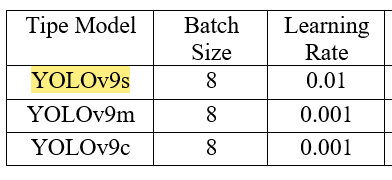

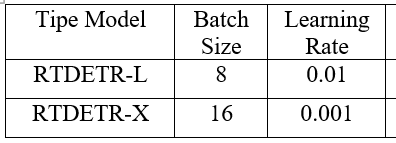

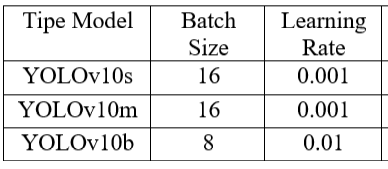

# 2nd way to inference

In [16]:
from ultralytics import YOLO
from ultralytics import RTDETR
import time

# === Load your trained model ===
model = YOLO("C:\\Users\\redoks\\Documents\\skripzii\\products6k\\YOLOv10\\YOLOv10b\\batch8_lr0.01\\weights\\best.pt")  # Replace with your model file

# === Start timer for full validation phase ===
start_time = time.time()

# === Run validation using the test set ===
results = model.val(
    data=r'C:\Users\redoks\Documents\skripzii\data\test_ready2\data-night.yaml',
    split='test',       # Force it to use the test split
    conf=0.382,           # Confidence threshold
    iou=0.5,             # IoU threshold
    imgsz=640,           # Image size (default from YOLO config)
    # max_det=300,         # Max detections per image
    device='cpu',
    cache=False,
)

# === End timer ===
end_time = time.time()

# === Print relevant metrics ===
print("\n=== Evaluation Results ===")
print(f"mAP@0.5:        {results.box.map50:.4f}")
print(f"mAP@0.5:0.95:   {results.box.map:.4f}")
print(f"Inference Time: {results.speed['inference']:.2f} ms/image")
print(f"Total Time:     {end_time - start_time:.2f} seconds")


Ultralytics 8.3.107  Python-3.12.0 torch-2.6.0+cpu CPU (Intel Core(TM) i5-8265U 1.60GHz)
YOLOv10b summary (fused): 165 layers, 20,429,656 parameters, 0 gradients, 98.0 GFLOPs


val: Scanning C:\Users\redoks\Documents\skripzii\data\test_ready2\test-night\labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:32<00:00,  8.16s/it]


                   all         56        533      0.639      0.295      0.467       0.22
               Bicycle         12         21      0.833      0.238      0.548     0.0818
                  Boat          7         12        0.5      0.167      0.319      0.114
                Bottle         14         26      0.444      0.154      0.312      0.101
                   Bus          3          3          1      0.667      0.833      0.417
                   Car          8         14      0.714      0.643      0.681      0.348
                   Cat          9         23          1      0.348      0.674      0.317
                 Chair         19        119      0.651      0.176      0.393      0.254
                   Cup          6        114          0          0          0          0
                   Dog          6         12        0.6       0.25      0.441      0.311
             Motorbike          6         18        0.5      0.167      0.374      0.227
                Peopl

# Pareto!


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Prepare the data ---
data = {
    "model": ["yolov9s", "yolov9m", "yolov9c", "rtdetr-l", "rtdetr-x", "yolov10s", "yolov10m", "yolov10b"],
    "map50_day": [0.3960, 0.555, 0.5465, 0.3632, 0.4924, 0.4056, 0.5165, 0.4935],
    "inference_day": [199.39, 442.15, 595.72, 1122.73, 1968.66, 176.96, 423.65, 593.39],
    "map50_night": [0.4365, 0.5566, 0.5629, 0.3513, 0.5205, 0.4336, 0.5473, 0.4666],
    "inference_night": [168.98, 392.85, 613.88, 1008.14, 2123.71, 148.62, 377.96, 559.03]
}
df = pd.DataFrame(data)

# --- Pareto Frontier Function ---
# For each model, we want high mAP50 and low inference time.
# A point is dominated if there exists another point that is both more accurate and faster.
def compute_pareto(df, score_col, cost_col):
    """
    Computes the Pareto frontier.
    
    Parameters:
        df (pd.DataFrame): Data frame with the data.
        score_col (str): Column name for accuracy metric (to be maximized).
        cost_col (str): Column name for inference time (to be minimized).
        
    Returns:
        frontier (pd.DataFrame): Subset of df that belongs to the Pareto frontier.
    """
    # Create an array of indices for points that are not dominated.
    is_dominated = np.zeros(df.shape[0], dtype=bool)
    for i in range(len(df)):
        for j in range(len(df)):
            # Skip comparing the point with itself
            if i == j:
                continue
            # If point j is at least as good in score and lower (or equal) in cost (with at least one improvement), mark i as dominated.
            if (df.loc[j, score_col] >= df.loc[i, score_col] and
                df.loc[j, cost_col] <= df.loc[i, cost_col] and
                (df.loc[j, score_col] > df.loc[i, score_col] or df.loc[j, cost_col] < df.loc[i, cost_col])):
                is_dominated[i] = True
                break
    return df[~is_dominated]

# --- Compute Pareto frontiers for day and night ---
pareto_day = compute_pareto(df, "map50_day", "inference_day")
pareto_night = compute_pareto(df, "map50_night", "inference_night")

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Day data plot (blue tone)
plt.scatter(df["inference_day"], df["map50_day"], color='skyblue', s=100, label='Day Models', edgecolors='black')
# Annotate day models
for i, row in df.iterrows():
    plt.annotate(row['model'], (row['inference_day']*1.01, row['map50_day']*1.01), color='blue', fontsize=9)

# Draw Pareto frontier for day models
# Sort frontier points by inference time for a connected line plot.
pareto_day_sorted = pareto_day.sort_values("inference_day")
plt.plot(pareto_day_sorted["inference_day"], pareto_day_sorted["map50_day"],
         color='blue', linestyle='-', linewidth=2, label='Pareto Day Frontier')

# Night data plot (red tone)
plt.scatter(df["inference_night"], df["map50_night"], color='lightcoral', s=100, label='Night Models', edgecolors='black')
# Annotate night models
for i, row in df.iterrows():
    plt.annotate(row['model'], (row['inference_night']*1.01, row['map50_night']*1.01), color='darkred', fontsize=9)

# Draw Pareto frontier for night models
pareto_night_sorted = pareto_night.sort_values("inference_night")
plt.plot(pareto_night_sorted["inference_night"], pareto_night_sorted["map50_night"],
         color='red', linestyle='-', linewidth=2, label='Pareto Night Frontier')

# --- Labels and Aesthetics ---
plt.xlabel("Inference Time (ms)", fontsize=12)
plt.ylabel("mAP50", fontsize=12)
plt.title("Pareto Frontier Visualization: Day vs. Night", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


<Figure size 1000x600 with 1 Axes>